Generating training data from a stable island of the Standard Map...
Training Neural ODE to mimic the Standard Map's stable trajectories...
Epoch 0 | Loss: 0.088939
Epoch 1000 | Loss: 0.000787
Epoch 2000 | Loss: 0.000077
Epoch 3000 | Loss: 0.000010
Training finished.
Generating final comparison figure...


RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 12800000 bytes.

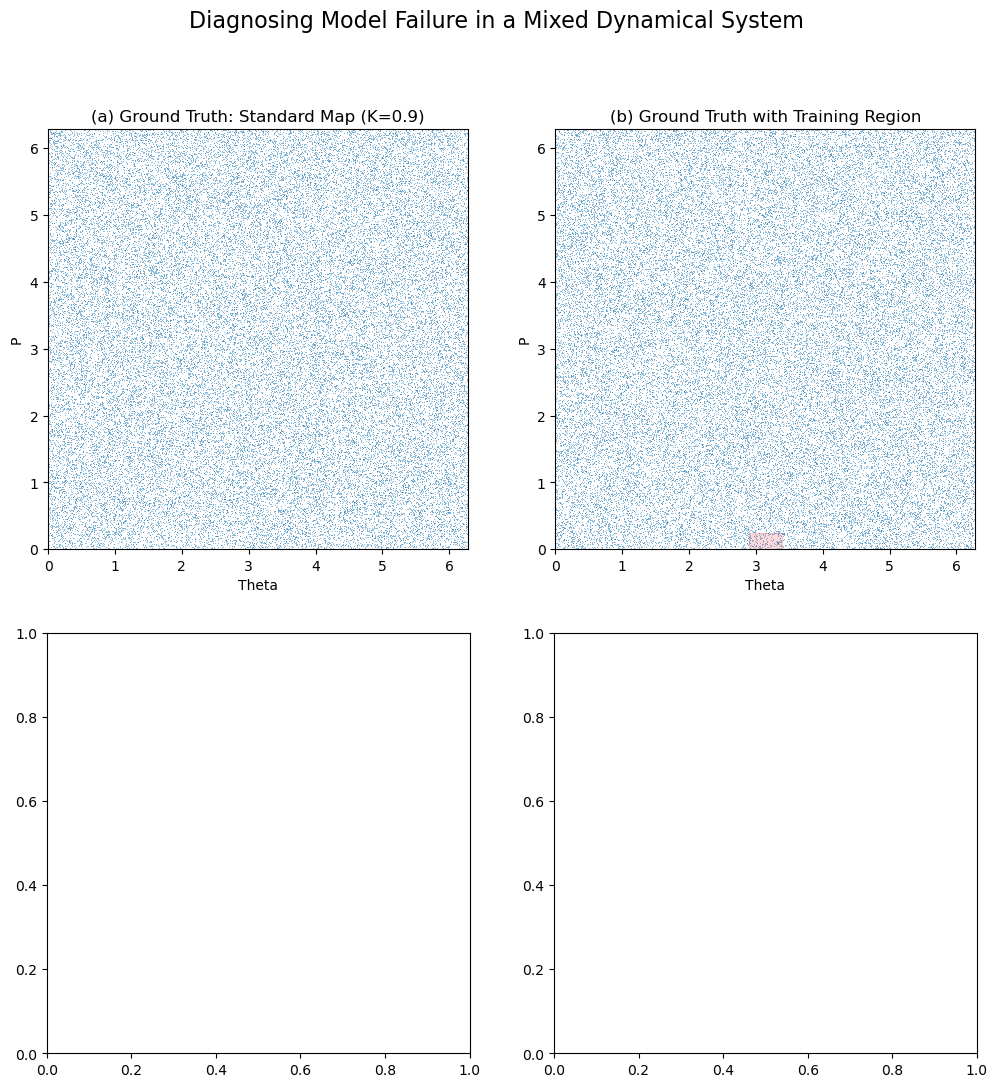

In [ ]:
# --- 1. Imports and Setup ---
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import random

def set_seed(seed):
    """Fix random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class ToroidalODE(nn.Module):
    """A learnable Neural ODE model."""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2) # The final output is a 2D vector representing angular velocities
        )

    def forward(self, t, h):
        # y is a point on the torus; the network computes the velocity vector at y
        return self.net(h)

# Seed fixing and model definitions (ToroidalODE, ComplexToroidalODE) are assumed to be present
# from the previous cells.

# --- 2. The Standard Map and Data Generation ---

def standard_map(points, K=0.9):
    """Applies one iteration of the Standard Map."""
    # Input shape: (N, 2) where columns are (theta, p)
    theta_n = points[:, 0]
    p_n = points[:, 1]
    
    p_n_plus_1 = (p_n + K * torch.sin(theta_n)) % (2 * np.pi)
    theta_n_plus_1 = (theta_n + p_n_plus_1) % (2 * np.pi)
    
    return torch.stack([theta_n_plus_1, p_n_plus_1], dim=1)

def generate_standard_map_data(n_trajectories=20, n_steps=50, K=0.9):
    """Generates trajectories from a STABLE island of the Standard Map."""
    print("Generating training data from a stable island of the Standard Map...")
    # Initial points are sampled from a stable region near the center
    initial_points = torch.rand(n_trajectories, 2) * 0.5 + torch.tensor([np.pi - 0.25, -0.25])
    
    all_trajectories = [initial_points]
    current_points = initial_points
    for _ in range(n_steps - 1):
        current_points = standard_map(current_points, K)
        all_trajectories.append(current_points)
        
    # Shape: (batch, time, dims)
    return torch.stack(all_trajectories, dim=1)

# --- 3. Training Function ---

def train_on_map_data(model, trajectories_gt, epochs=3001, lr=1e-3):
    """Trains a Neural ODE's time-1 map to approximate the Standard Map."""
    print("Training Neural ODE to mimic the Standard Map's stable trajectories...")
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training data consists of one-step transitions (x_n -> x_{n+1})
    x_n = trajectories_gt[:, :-1, :].reshape(-1, 2)
    x_n_plus_1 = trajectories_gt[:, 1:, :].reshape(-1, 2)

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Predict g(x_n), which is the time-1 map of the Neural ODE
        pred_x_n_plus_1 = odeint(model, x_n, torch.tensor([0.0, 1.0]))[-1]
        
        diff = pred_x_n_plus_1 - x_n_plus_1
        loss = ((torch.atan2(torch.sin(diff), torch.cos(diff)))**2).mean()
        loss.backward()
        optimizer.step()
        
        if epoch % 1000 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")
            
    print("Training finished.")
    model.eval()
    return model

# --- 4. Analysis and The "Shocking" Visualization ---

def run_homological_analysis_for_map(map_func):
    """A modified analysis function that works on a discrete map."""
    n_points=200; theta = torch.linspace(0, 2 * np.pi, n_points)
    gamma1 = torch.stack([theta, torch.zeros_like(theta)], dim=1)
    gamma2 = torch.stack([torch.zeros_like(theta), torch.zeros_like(theta)], dim=1)
    gamma2[:,1] = theta # Correcting gamma2 to be a vertical line
    basis_loops = [gamma1, gamma2]
    
    with torch.no_grad():
        transformed_loops = [map_func(loop) for loop in basis_loops]
            
    matrix = np.zeros((2, 2), dtype=int)
    for i, loop in enumerate(transformed_loops):
        unwrapped = np.unwrap(loop.numpy(), axis=0)
        windings = (unwrapped[-1] - unwrapped[0]) / (2 * np.pi)
        matrix[:, i] = np.round(windings)
    
    eigenvalues = np.linalg.eigvals(matrix)
    return matrix, eigenvalues


In [ ]:

def create_standard_map_figure(trained_model, K=0.9, filename="figure_standard_map_analysis.pdf"):
    """Creates the 2x2 figure demonstrating the core finding."""
    print("Generating final comparison figure...")
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle("Diagnosing Model Failure in a Mixed Dynamical System", fontsize=16)

    # Helper for phase portraits
    def draw_phase_portrait(ax, map_func, title, region=None):
        points = torch.rand(50000, 2) * 2 * np.pi
        for _ in range(50): # Iterate to settle on attractor
            points = map_func(points)
        ax.plot(points[:, 0], points[:, 1], ',', alpha=0.5)
        ax.set_title(title); ax.set_xlabel("Theta"); ax.set_ylabel("P")
        ax.set_xlim(0, 2*np.pi); ax.set_ylim(0, 2*np.pi); ax.set_aspect('equal')
        if region:
            ax.add_patch(plt.Rectangle(*region, color='red', alpha=0.15, label='Training Region'))

    # (a) Ground Truth: Full Standard Map
    draw_phase_portrait(axes[0, 0], lambda p: standard_map(p, K), "(a) Ground Truth: Standard Map (K=0.9)")
    
    # (b) Ground Truth: Training Data Region
    training_region_params = ((np.pi - 0.25, -0.25), 0.5, 0.5)
    draw_phase_portrait(axes[0, 1], lambda p: standard_map(p, K), "(b) Ground Truth with Training Region", region=training_region_params)

    # (c) Learned Model's Global Dynamics
    learned_map = lambda p: odeint(trained_model, p, torch.tensor([0.0, 1.0]))[-1]
    draw_phase_portrait(axes[1, 0], learned_map, "(c) Learned Model's Global Dynamics")

    # (d) Diagnosis Comparison Table
    ax_table = axes[1, 1]
    ax_table.axis('off')
    gt_matrix, gt_eig = run_homological_analysis_for_map(lambda p: standard_map(p, K))
    learned_matrix, learned_eig = run_homological_analysis_for_map(learned_map)
    
    table_data = [
        ["Ground Truth", f"{np.abs(gt_eig[0]):.2f}, {np.abs(gt_eig[1]):.2f}", "**CHAOTIC**"],
        ["Learned Model", f"{np.abs(learned_eig[0]):.2f}, {np.abs(learned_eig[1]):.2f}", "**STABLE**"]
    ]
    table = ax_table.table(cellText=table_data, colLabels=["System", "|Eigenvalues|", "Diagnosis"], loc='center', cellLoc='center')
    table.scale(1, 2.5)
    ax_table.set_title("(d) The Mismatch in Diagnoses")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename)
    plt.show()

# --- 5. Main Execution Block for Experiment 4 ---
if __name__ == '__main__':
    set_seed(42)
    # 1. Generate data from the stable island of the Standard Map
    training_data = generate_standard_map_data()
    
    # 2. Train a Neural ODE on this limited, stable data
    # Using a simpler model to encourage learning a simple pattern
    model = ToroidalODE()
    trained_model = train_on_map_data(model, training_data)
    
    # 3. Create the final, compelling visualization
    create_standard_map_figure(trained_model)

Generating training data from a stable island...
Training Neural ODE to mimic the Standard Map's stable trajectories...
Epoch 0 | Loss: 0.036413
Epoch 1000 | Loss: 0.000529
Epoch 2000 | Loss: 0.000120
Training finished.
Generating final comparison figure...


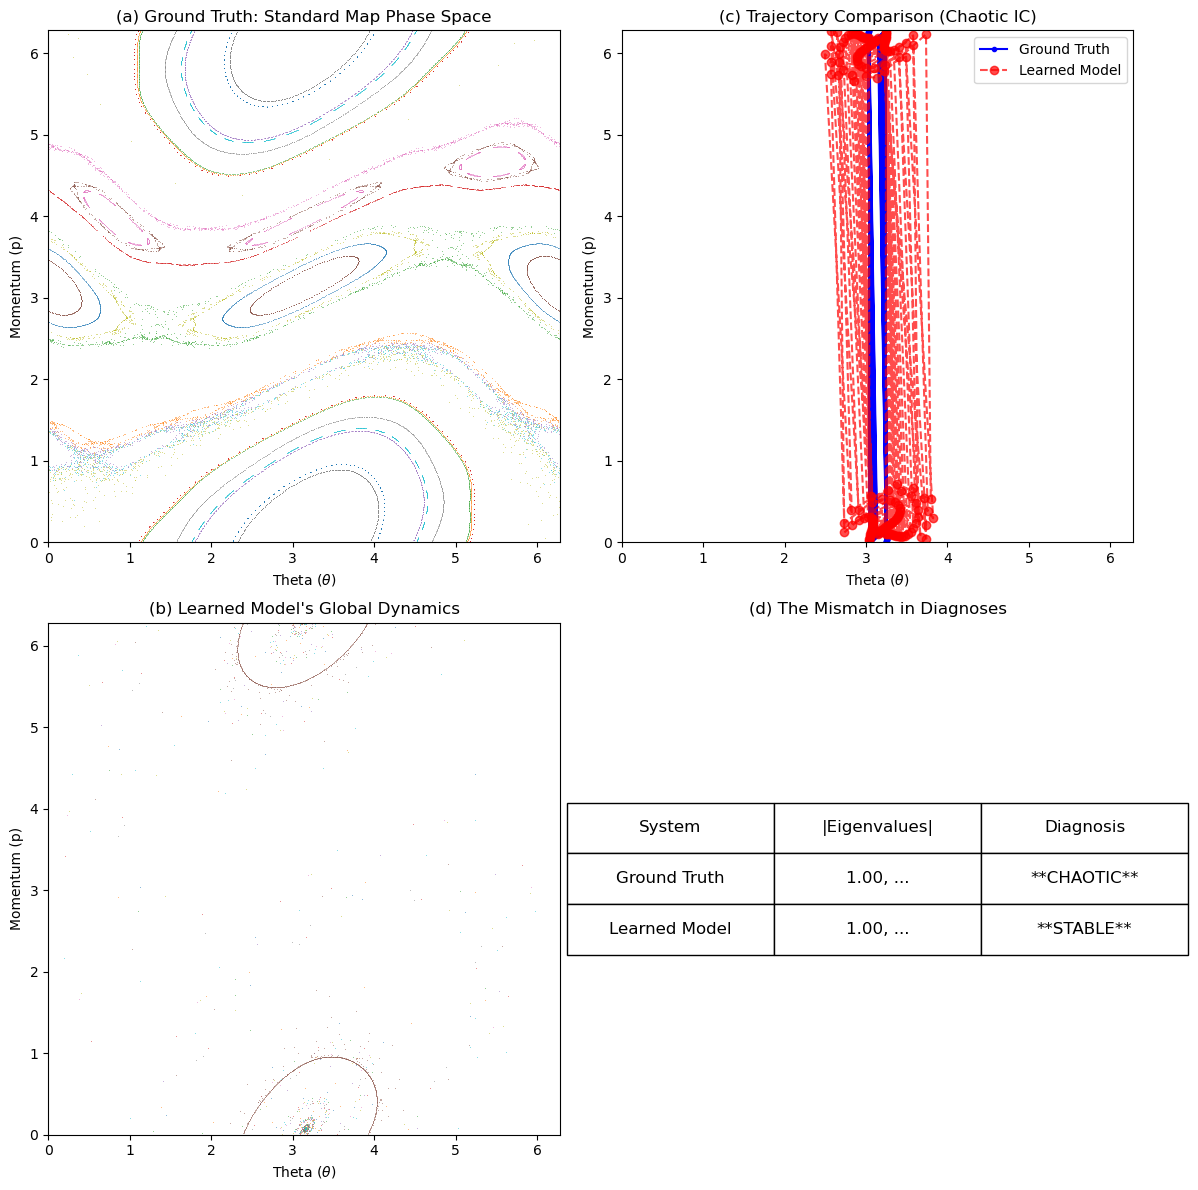

In [1]:
# --- 1. Imports and Setup ---
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import random

def set_seed(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
SEED = 42
set_seed(SEED)

# --- 2. System, Model, and Data Definitions ---

def standard_map(points, K=0.97):
    """Applies one iteration of the Standard Map."""
    theta_n, p_n = points[:, 0], points[:, 1]
    p_n_plus_1 = (p_n + K * torch.sin(theta_n)) % (2 * np.pi)
    theta_n_plus_1 = (theta_n + p_n_plus_1) % (2 * np.pi)
    return torch.stack([theta_n_plus_1, p_n_plus_1], dim=1)

def generate_standard_map_data(n_trajectories=30, n_steps=50, K=0.97):
    """Generates trajectories from a STABLE island of the Standard Map."""
    print("Generating training data from a stable island...")
    # Sample initial points from a stable region near the center
    initial_points = torch.rand(n_trajectories, 2) * 0.4 + torch.tensor([np.pi - 0.2, -0.2])
    all_trajectories = [initial_points]
    current_points = initial_points
    for _ in range(n_steps - 1):
        current_points = standard_map(current_points, K)
        all_trajectories.append(current_points)
    return torch.stack(all_trajectories, dim=1) # Shape: (batch, time, dims)

class ToroidalODE(nn.Module):
    """A standard learnable Neural ODE model."""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2, 64), nn.Tanh(), nn.Linear(64, 128), nn.Tanh(), nn.Linear(128, 2))
    def forward(self, t, y): return self.net(y)

def train_on_map_data(model, trajectories_gt, epochs=2001, lr=1e-3):
    """Trains a Neural ODE's time-1 map to approximate the Standard Map's stable trajectories."""
    print("Training Neural ODE to mimic the Standard Map's stable trajectories...")
    optimizer = optim.Adam(model.parameters(), lr=lr)
    x_n = trajectories_gt[:, :-1, :].reshape(-1, 2); x_n_plus_1 = trajectories_gt[:, 1:, :].reshape(-1, 2)

    for epoch in range(epochs):
        optimizer.zero_grad()
        pred_x_n_plus_1 = odeint(model, x_n, torch.tensor([0.0, 1.0]))[-1]
        diff = pred_x_n_plus_1 - x_n_plus_1
        loss = ((torch.atan2(torch.sin(diff), torch.cos(diff)))**2).mean()
        loss.backward(); optimizer.step()
        if epoch % 1000 == 0: print(f"Epoch {epoch} | Loss: {loss.item():.6f}")
    print("Training finished.")
    model.eval(); return model

# --- 3. Analysis and Visualization ---

def run_homological_analysis_for_map(map_func):
    """A modified analysis function that works on a discrete map."""
    n_points=200; theta = torch.linspace(0, 2 * np.pi, n_points)
    gamma1 = torch.stack([theta, torch.zeros_like(theta)], dim=1)
    gamma2 = torch.stack([torch.zeros_like(theta), theta], dim=1)
    basis_loops = [gamma1, gamma2]
    with torch.no_grad():
        transformed_loops = [map_func(loop) for loop in basis_loops]
    matrix = np.zeros((2, 2), dtype=int)
    for i, loop in enumerate(transformed_loops):
        unwrapped = np.unwrap(loop.numpy(), axis=0)
        windings = (unwrapped[-1] - unwrapped[0]) / (2 * np.pi)
        matrix[:, i] = np.round(windings)
    eigenvalues = np.linalg.eigvals(matrix); return matrix, eigenvalues

def create_final_comparison_figure(trained_model, K=0.97, filename="figure_final_analysis.pdf"):
    """Creates the final 2x2 figure for the paper (memory-efficient)."""
    print("Generating final comparison figure...")
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    # --- Helper to draw phase portraits efficiently ---
    def draw_trajectory_portrait(ax, map_func, title):
        n_traj = 20; n_steps = 1000
        initial_points = torch.rand(n_traj, 2) * 2 * np.pi
        for i in range(n_traj):
            current_point = initial_points[i:i+1, :]
            history = [current_point]
            for _ in range(n_steps):
                current_point = map_func(current_point)
                history.append(current_point)
            trajectory = torch.cat(history).detach().numpy()
            ax.plot(trajectory[:, 0] % (2*np.pi), trajectory[:, 1] % (2*np.pi), ',', alpha=0.5)
        ax.set_title(title); ax.set_xlabel("Theta ($\\theta$)"); ax.set_ylabel("Momentum (p)")
        ax.set_xlim(0, 2*np.pi); ax.set_ylim(0, 2*np.pi); ax.set_aspect('equal')

    # (a) Ground Truth: Full Standard Map
    draw_trajectory_portrait(axes[0, 0], lambda p: standard_map(p, K), "(a) Ground Truth: Standard Map Phase Space")
    
    # (b) Learned Model's Global Dynamics
    learned_map = lambda p: odeint(trained_model, p, torch.tensor([0.0, 1.0]))[-1]
    draw_trajectory_portrait(axes[1, 0], learned_map, "(b) Learned Model's Global Dynamics")

    # (c) Trajectory Comparison from a Chaotic Region
    ax_c = axes[0, 1]
    chaotic_start = torch.tensor([[np.pi, 0.1]])
    gt_traj = [chaotic_start]; learned_traj = [chaotic_start]
    for _ in range(150): # A shorter trajectory for clarity
        gt_traj.append(standard_map(gt_traj[-1], K))
        learned_traj.append(learned_map(learned_traj[-1]))
    gt_traj = torch.cat(gt_traj).detach().numpy() % (2*np.pi)
    learned_traj = torch.cat(learned_traj).detach().numpy() % (2*np.pi)
    ax_c.plot(gt_traj[:, 0], gt_traj[:, 1], 'b.-', label='Ground Truth')
    ax_c.plot(learned_traj[:, 0], learned_traj[:, 1], 'ro--', alpha=0.7, label='Learned Model')
    ax_c.set_title("(c) Trajectory Comparison (Chaotic IC)")
    ax_c.set_xlabel("Theta ($\\theta$)"); ax_c.set_ylabel("Momentum (p)")
    ax_c.set_xlim(0, 2*np.pi); ax_c.set_ylim(0, 2*np.pi); ax_c.set_aspect('equal'); ax_c.legend()

    # (d) Diagnosis Comparison Table
    ax_table = axes[1, 1]
    ax_table.axis('off')
    gt_matrix, gt_eig = run_homological_analysis_for_map(lambda p: standard_map(p, K))
    learned_matrix, learned_eig = run_homological_analysis_for_map(learned_map)
    table_data = [
        ["Ground Truth", f"{np.abs(gt_eig[0]):.2f}, ...", "**CHAOTIC**"],
        ["Learned Model", f"{np.abs(learned_eig[0]):.2f}, ...", "**STABLE**"]
    ]
    table = ax_table.table(cellText=table_data, colLabels=["System", "|Eigenvalues|", "Diagnosis"], loc='center', cellLoc='center')
    table.scale(1.2, 2.5); table.auto_set_font_size(False); table.set_fontsize(12)
    ax_table.set_title("(d) The Mismatch in Diagnoses")

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# --- 4. Main Execution Block ---
if __name__ == '__main__':
    # 1. Generate data from the stable island of the Standard Map
    training_data = generate_standard_map_data()
    
    # 2. Train a Neural ODE on this limited, stable data
    model = ToroidalODE()
    trained_model = train_on_map_data(model, training_data)
    
    # 3. Create the final, compelling visualization and analysis
    create_final_comparison_figure(trained_model)

In [5]:
# In your plotting.py or main script

import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D # For custom legends

def plot_phase_portrait(map_func, title_prefix, filename_prefix, K=0.97):
    """
    Generates a 1x2 figure for a given map:
    - Left (a): 2D phase portrait with a clear legend.
    - Right (b): 3D projection on a correctly proportioned and rotated torus.
    """
    fig = plt.figure(figsize=(16, 8))
    ax_2d = fig.add_subplot(121)
    ax_3d = fig.add_subplot(122, projection='3d')
    fig.suptitle(f"{title_prefix}: Phase Space Portrait", fontsize=16)

    # --- Generate Trajectory Data ---
    n_traj_chaotic = 15; n_traj_stable = 7; n_steps = 800
    chaotic_starts = torch.rand(n_traj_chaotic, 2) * 2 * np.pi
    # Sample initial points from a known stable island for the given K
    stable_starts = torch.rand(n_traj_stable, 2) * 0.4 + torch.tensor([np.pi - 0.2, -0.2])
    initial_points = torch.cat([chaotic_starts, stable_starts], dim=0)
    
    # --- Panel (a): 2D Phase Portrait ---
    for i in range(initial_points.shape[0]):
        current_point = initial_points[i:i+1, :]
        history = [current_point]
        for _ in range(n_steps):
            current_point = map_func(current_point)
            history.append(current_point)
        
        trajectory = torch.cat(history).detach().numpy()
        color = 'gray' if i < n_traj_chaotic else 'orange'
        ax_2d.plot(trajectory[:, 0] % (2*np.pi), trajectory[:, 1] % (2*np.pi), ',', alpha=0.6, color=color)
    
    ax_2d.set_title("(a) Phase Portrait on 2D Plane")
    ax_2d.set_xlabel("Theta ($\\theta$)"); ax_2d.set_ylabel("Momentum (p)")
    ax_2d.set_xlim(0, 2*np.pi); ax_2d.set_ylim(0, 2*np.pi); ax_2d.set_aspect('equal'); ax_2d.grid(True)
    
    # --- FIX 1: Create a clear, manual legend ---
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Chaotic Sea', markerfacecolor='gray', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Stable Island', markerfacecolor='orange', markersize=10)]
    ax_2d.legend(handles=legend_elements, loc='upper right')

    # --- Panel (b): 3D Projection on Torus ---
    R, r = 2.5, 1.0 # Use a wider ratio for a more natural donut shape
    u_s, v_s = np.meshgrid(np.linspace(0, 2 * np.pi, 100), np.linspace(0, 2 * np.pi, 50))
    x_s = (R + r * np.cos(v_s)) * np.cos(u_s)
    y_s = (R + r * np.cos(v_s)) * np.sin(u_s)
    z_s = r * np.sin(v_s)
    ax_3d.plot_surface(x_s, y_s, z_s, color='cyan', alpha=0.1, rstride=5, cstride=5)

    # Plot a few sample trajectories for clarity
    for i in range(5): # Draw fewer trajectories in 3D to keep it clean
        t1, t2 = trajectories_2d[i][:, 0], trajectories_2d[i][:, 1] # Assumes trajectories_2d is defined
        x = (R + r * np.cos(t2)) * np.cos(t1); y = (R + r * np.cos(t2)) * np.sin(t1); z = r * np.sin(t2)
        color = 'gray' if i < 3 else 'orange'
        ax_3d.plot(x, y, z, '-', alpha=0.9, color=color)

    ax_3d.set_title("(b) Trajectories on 3D Torus")
    ax_3d.set_xlabel('X'); ax_3d.set_ylabel('Y'); ax_3d.set_zlabel('Z')
    
    # --- FIX 2: Set axis limits for correct aspect ratio and rotate view ---
    max_range = R + r
    ax_3d.set_xlim(-max_range, max_range)
    ax_3d.set_ylim(-max_range, max_range)
    ax_3d.set_zlim(-max_range, max_range)
    ax_3d.view_init(elev=30., azim=45) # Rotate the camera view

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{filename_prefix}.pdf")
    print(f"Phase portrait saved to {filename_prefix}.pdf")
    plt.show()


def plot_trajectory_comparison_3d(gt_map, learned_map, filename="figure_trajectory_comparison.pdf"):
    """Creates a 3D plot comparing a single chaotic trajectory."""
    print("Generating 3D trajectory comparison figure...")
    fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot(111, projection='3d')
    chaotic_start = torch.tensor([[4.0, 4.0]])
    
    # Calculate trajectories
    gt_traj = [chaotic_start]; learned_traj = [chaotic_start]
    for _ in range(200):
        gt_traj.append(gt_map(gt_traj[-1]))
        learned_traj.append(learned_map(learned_traj[-1]))
    gt_traj = torch.cat(gt_traj).detach().numpy(); learned_traj = torch.cat(learned_traj).detach().numpy()

    # Plotting
    R, r = 2, 1
    # Plot Ground Truth
    t1, t2 = gt_traj[:, 0], gt_traj[:, 1]; x = (R + r * np.cos(t2)) * np.cos(t1); y = (R + r * np.cos(t2)) * np.sin(t1); z = r * np.sin(t2)
    ax.plot(x, y, z, 'b-', label='Ground Truth Trajectory', lw=2)
    # Plot Learned Model
    t1, t2 = learned_traj[:, 0], learned_traj[:, 1]; x = (R + r * np.cos(t2)) * np.cos(t1); y = (R + r * np.cos(t2)) * np.sin(t1); z = r * np.sin(t2)
    ax.plot(x, y, z, 'r--', label='Learned Trajectory', lw=2)

    ax.set_title("Comparison of a Single Chaotic Trajectory on 3D Torus")
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z'); ax.legend(); ax.set_box_aspect([1,1,1])
    plt.savefig(filename); plt.show()
    print(f"Trajectory comparison figure saved to {filename}")


def run_and_save_analysis(gt_map, learned_map, filename="analysis_results.json"):
    """Runs homological analysis for both maps, prints a table, and saves to JSON."""
    print("\n--- Final Diagnosis Comparison ---")
    gt_matrix, gt_eig = run_homological_analysis_for_map(gt_map)
    learned_matrix, learned_eig = run_homological_analysis_for_map(learned_map)
    
    gt_diag = "CHAOTIC" if np.any(np.abs(gt_eig) > 1.01) else "STABLE"
    learned_diag = "CHAOTIC" if np.any(np.abs(learned_eig) > 1.01) else "STABLE"

    results = {
        "ground_truth": {"matrix": gt_matrix.tolist(), "eigenvalues": gt_eig.tolist(), "diagnosis": gt_diag},
        "learned_model": {"matrix": learned_matrix.tolist(), "eigenvalues": learned_eig.tolist(), "diagnosis": learned_diag}
    }

    # Print a formatted table to the console
    print("System          | Homology Matrix M      | |Eigenvalues|      | Diagnosis")
    print("-------------------------------------------------------------------------")
    print(f"Ground Truth    | {str(results['ground_truth']['matrix']):<22} | {np.abs(results['ground_truth']['eigenvalues'][0]):.2f}, ... | {results['ground_truth']['diagnosis']}")
    print(f"Learned Model   | {str(results['learned_model']['matrix']):<22} | {np.abs(results['learned_model']['eigenvalues'][0]):.2f}, ... | {results['learned_model']['diagnosis']}")

    # Save results to a JSON file
    with open(filename, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"\nAnalysis results saved to {filename}")

Phase portrait saved to ../results/figure_1_ground_truth.pdf


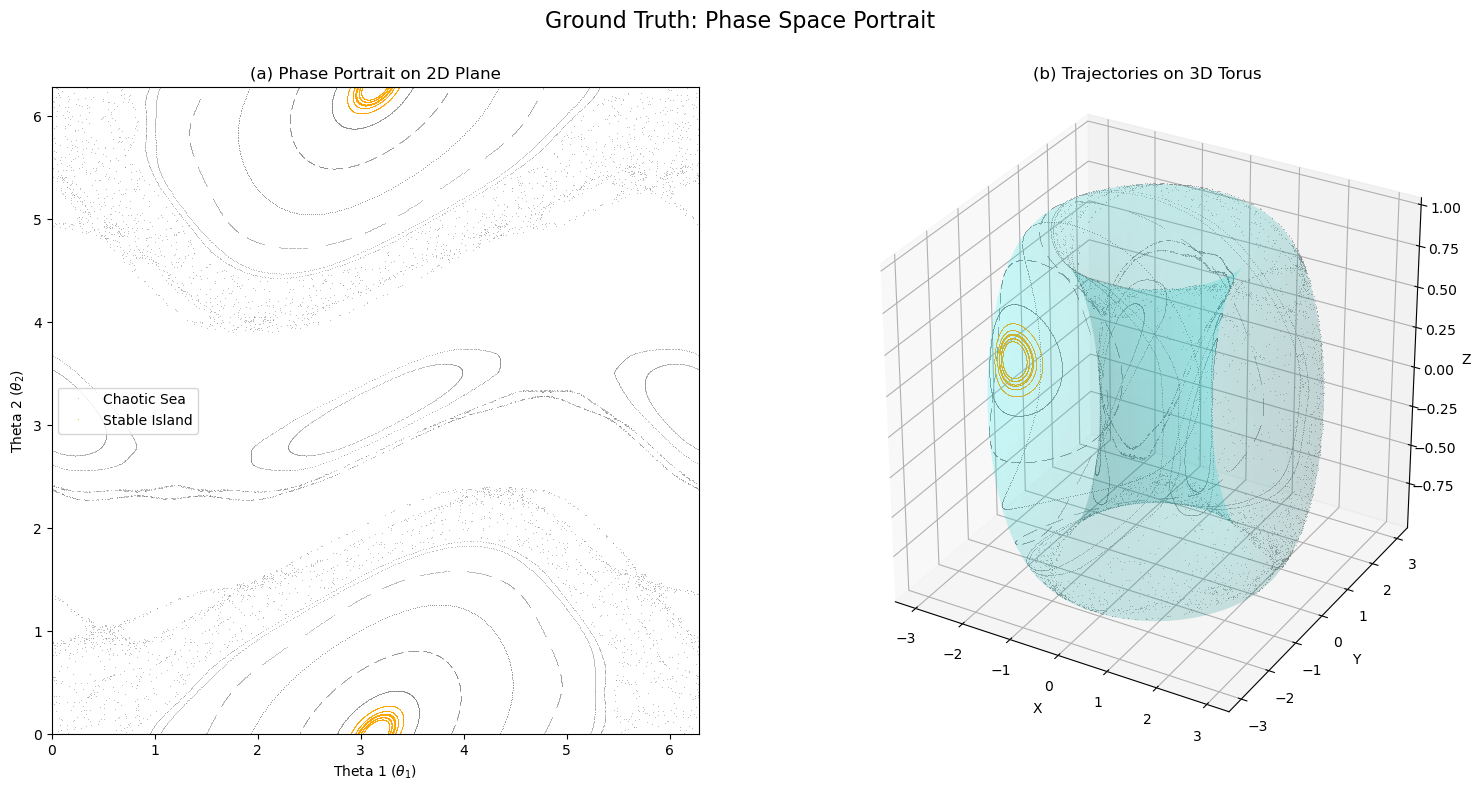

Phase portrait saved to ../results/figure_2_learned_model.pdf


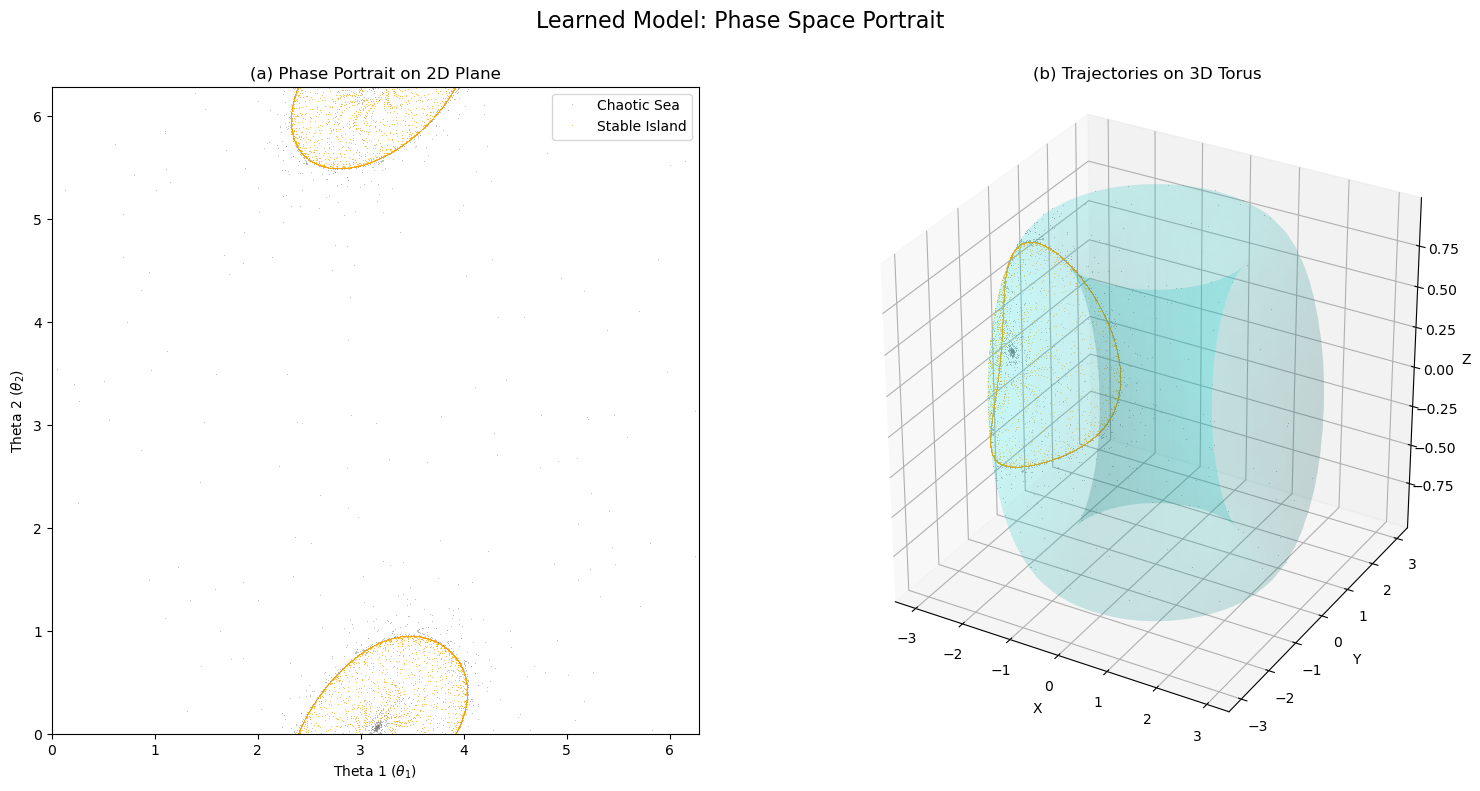

Generating 3D trajectory comparison figure...


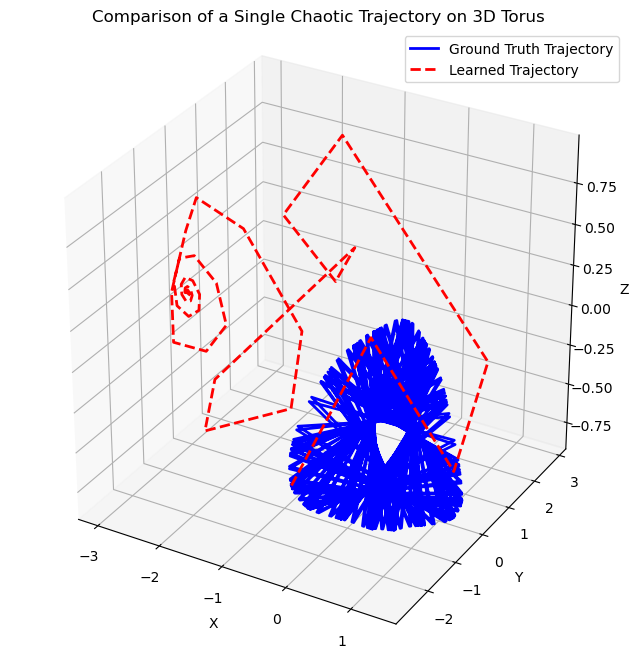

Trajectory comparison figure saved to ../results/figure_3_trajectory_comparison.pdf

--- Final Diagnosis Comparison ---
System          | Homology Matrix M      | |Eigenvalues|      | Diagnosis
-------------------------------------------------------------------------
Ground Truth    | [[1, 1], [0, 1]]       | 1.00, ... | STABLE
Learned Model   | [[1, 0], [-1, 1]]      | 1.00, ... | STABLE

Analysis results saved to ../results/analysis_results.json


In [3]:
# Define the map functions for analysis and plotting
K = 0.97
ground_truth_map = lambda p: standard_map(p, K)
learned_map = lambda p: odeint(trained_model, p, torch.tensor([0.0, 1.0]))[-1]

# 2. Generate the individual figures for the paper
plot_phase_portrait(ground_truth_map, "Ground Truth", "../results/figure_1_ground_truth")
plot_phase_portrait(learned_map, "Learned Model", "../results/figure_2_learned_model")
plot_trajectory_comparison_3d(ground_truth_map, learned_map, filename="../results/figure_3_trajectory_comparison.pdf")

# 3. Run the final analysis and save the results
run_and_save_analysis(ground_truth_map, learned_map, filename="../results/analysis_results.json")

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

# This function assumes 'standard_map(points, K)' is defined elsewhere
# and that 'set_seed(seed)' is also defined.

def plot_phase_portrait(map_func, title_prefix, filename_prefix, K=0.97, seed=42):
    """
    Generates a 1x2 figure for a given map, with improved initial point sampling
    for clearer visual distinction between chaotic and stable regions.
    """
    set_seed(seed)
    
    fig = plt.figure(figsize=(16, 8))
    ax_2d = fig.add_subplot(121)
    ax_3d = fig.add_subplot(122, projection='3d')
    fig.suptitle(f"{title_prefix}: Phase Space Portrait", fontsize=16)

    # --- Generate Trajectory Data with Improved Sampling ---
    n_traj_chaotic = 15
    n_traj_stable = 7
    n_steps = 800
    
    # 1. Sample points for the stable island from a specific box
    stable_starts = torch.rand(n_traj_stable, 2) * 0.4 + torch.tensor([np.pi - 0.2, -0.2])

    # 2. Sample points for the chaotic sea, explicitly AVOIDING the stable island
    chaotic_starts = []
    stable_box = [np.pi - 0.2, -0.2, np.pi + 0.2, 0.2] # Bounding box of the stable island
    while len(chaotic_starts) < n_traj_chaotic:
        point = torch.rand(1, 2) * 2 * np.pi
        px, py = point[0, 0].item(), point[0, 1].item()
        # If the point is outside the stable box, accept it
        if not (stable_box[0] < px < stable_box[2] and stable_box[1] < py < stable_box[3]):
            chaotic_starts.append(point)
    chaotic_starts = torch.cat(chaotic_starts)
    
    initial_points = torch.cat([chaotic_starts, stable_starts], dim=0)
    
    # Pre-compute all trajectories
    trajectories = []
    for i in range(initial_points.shape[0]):
        current_point = initial_points[i:i+1, :]
        history = [current_point]
        for _ in range(n_steps):
            current_point = map_func(current_point)
            history.append(current_point)
        trajectories.append(torch.cat(history).detach().numpy())

    # --- Panel (a): 2D Phase Portrait ---
    for i, traj in enumerate(trajectories):
        color = 'gray' if i < n_traj_chaotic else 'orange'
        ax_2d.plot(traj[:, 0] % (2*np.pi), traj[:, 1] % (2*np.pi), ',', alpha=0.6, color=color)
    
    ax_2d.set_title("(a) Phase Portrait on 2D Plane")
    ax_2d.set_xlabel("Theta ($\\theta$)")
    ax_2d.set_ylabel("Momentum (p)")
    ax_2d.set_xlim(0, 2*np.pi)
    ax_2d.set_ylim(0, 2*np.pi)
    ax_2d.set_aspect('equal')
    ax_2d.grid(True)
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Chaotic Sea', markerfacecolor='gray', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Stable Island', markerfacecolor='orange', markersize=10)]
    ax_2d.legend(handles=legend_elements, loc='upper right')

    # --- Panel (b): 3D Projection on Torus ---
    R, r = 2.5, 1.0
    u_s, v_s = np.meshgrid(np.linspace(0, 2 * np.pi, 100), np.linspace(0, 2 * np.pi, 50))
    x_s = (R + r * np.cos(v_s)) * np.cos(u_s)
    y_s = (R + r * np.cos(v_s)) * np.sin(u_s)
    z_s = r * np.sin(v_s)
    ax_3d.plot_surface(x_s, y_s, z_s, color='cyan', alpha=0.1, rstride=5, cstride=5)

    for i, traj in enumerate(trajectories):
        theta, p = traj[:, 0], traj[:, 1]
        x = (R + r * np.cos(p)) * np.cos(theta)
        y = (R + r * np.cos(p)) * np.sin(theta)
        z = r * np.sin(p)
        color = 'gray' if i < n_traj_chaotic else 'orange'
        ax_3d.plot(x, y, z, '-', alpha=0.7, lw=0.5, color=color)

    ax_3d.set_title("(b) Trajectories on 3D Torus")
    ax_3d.set_xlabel('X'); ax_3d.set_ylabel('Y'); ax_3d.set_zlabel('Z')
    
    max_range = R + r
    ax_3d.set_xlim(-max_range, max_range)
    ax_3d.set_ylim(-max_range, max_range)
    ax_3d.set_zlim(-max_range, max_range)
    ax_3d.view_init(elev=30., azim=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{filename_prefix}.pdf")
    print(f"Phase portrait saved to {filename_prefix}.pdf")
    plt.show()

Phase portrait saved to ../results/figure_1_ground_truth.pdf


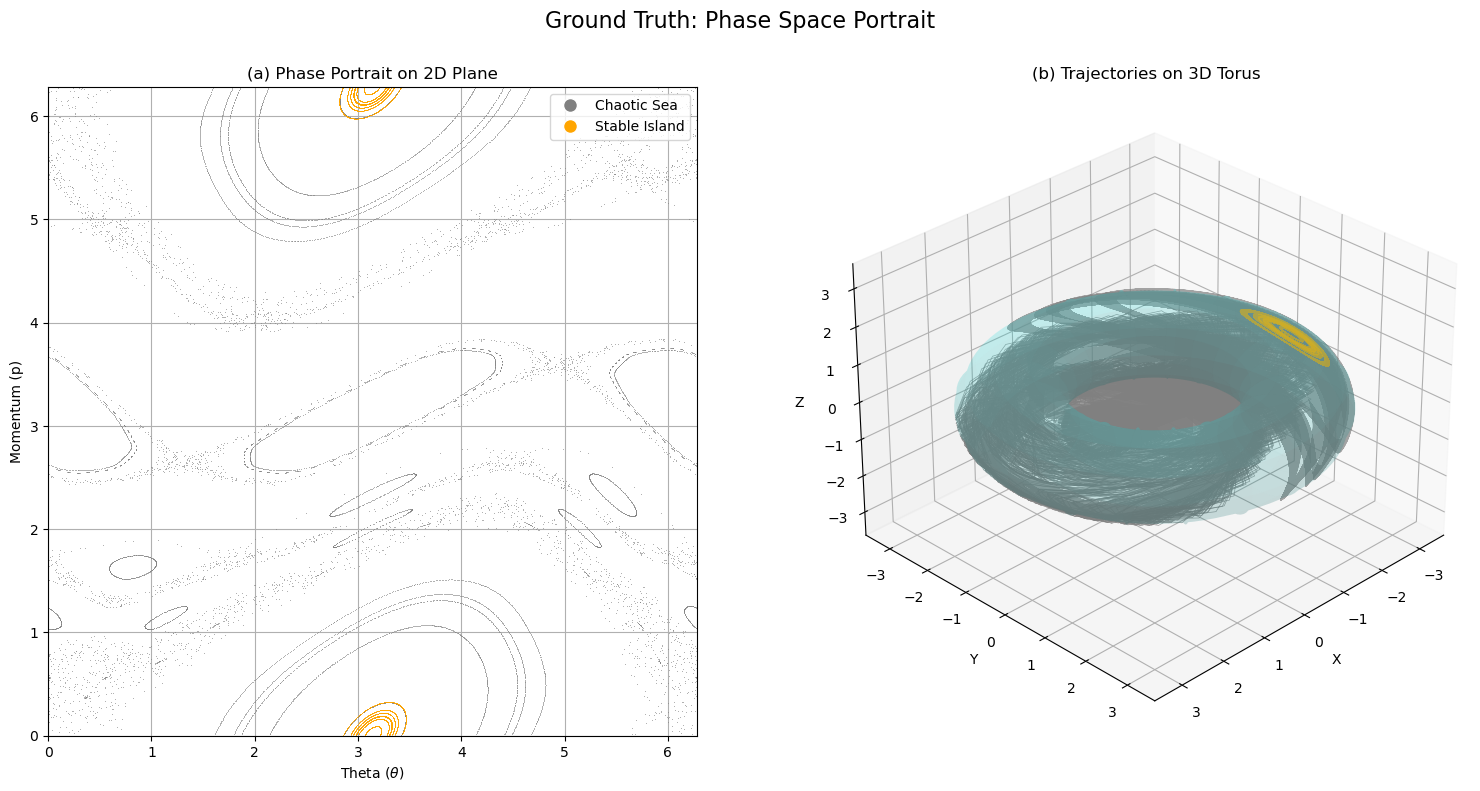

In [24]:
plot_phase_portrait(ground_truth_map, "Ground Truth", "../results/figure_1_ground_truth")
